**ResNet Variational Autoencoder**

Reference code used:


1.   https://github.com/LukeDitria/CNN-VAE
2.   https://github.com/hsinyilin19/ResNetVAE/blob/master/ResNetVAE_reconstruction.ipynb

Side note: I also used "Deep Learning with PyTorch" by Eli Stevens, Luca Antiga and Thomas Viehmann, to help guide me through this coursework, some of the code here might look familar from Chapters 7 & 8 (specifically the dataset loading code).

Another side note: I tried deeper architectures comparable to ResNet18 and ResNet34, which I used the code from https://github.com/julianstastny/VAE-ResNet18-PyTorch/blob/master/model.py to help build. While these models gave better image reconstruction, the sampled pegasuses were worse.




In [1]:
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

'''hyper params'''
batch_size  = 64
image_size = 64
n_channels  = 3
latent_size = 512
learning_rate = 1e-4
n_epoch = 100
start_epoch = 0
load_save  = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''download the datasets and setup the training loaders / data iterators'''

# train set used for training the VAE for reconstructing images
train_set = datasets.STL10('drive/My Drive/training/stl10', split='train+unlabeled', download=True,
                                      transform=transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                      ]))

# test set used for visualizing image reconstruction
test_set = datasets.STL10('drive/My Drive/training/stl10', split='test', download=True,
                                      transform=transforms.Compose([
                                          transforms.Resize(image_size),
                                          transforms.ToTensor(),
                                      ]))

# sample set used for sampling pegasus at the end
sample_set = datasets.STL10('drive/My Drive/training/stl10', split='test', download=True,
                                      transform=transforms.Compose([
                                          transforms.Resize(image_size),                                            
                                          transforms.ToTensor(),
                                      ]))

label_map = {1:0, 6:2}
class_names = ['bird', 'horse']

# construct hand-picked batch of 64 horses from the sample set
horse_sample_set = [(img, label_map[label]) for img, label in sample_set if label == 6]
horse_indices = [5,14,15,45,57,64,77,86,90,95,103,131,132,136,225,237,259,270,271,277,
                 290,291,297,335,341,344,360,361,363,386,387,391,393,408,409,421,432,
                 450,480,489,501,503,535,547,561,582,609,631,638,643,648,660,687,694,
                 697,718,731,752,759,769,771,785,789,798]
horse_subset = torch.utils.data.Subset(horse_sample_set, horse_indices)

# construct hand-picked batch of 64 birds from the sample set
bird_sample_set = [(img, label_map[label]) for img, label in sample_set if label == 1]
bird_indices = [33,40,62,63,88,90,95,97,111,124,126,128,144,149,154,158,168,176,186,190,
                197,199,203,218,219,231,243,253,255,289,307,313,317,352,396,415,429,452,
                453,477,483,491,503,521,528,535,556,566,579,586,592,600,633,667,671,677,
                685,693,740,742,745,766,767,783]
bird_subset = torch.utils.data.Subset(bird_sample_set, bird_indices)

# test set only has horses (because thats what we care about)
test_set = [(img, label_map[label]) for img, label in test_set if label == 6]

# train loder
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size//2, shuffle=True, drop_last=True)

# test data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

# test data iterators
test_iter = iter(test_loader)

# sample loaders
horse_sample_loader = torch.utils.data.DataLoader(horse_subset, batch_size=batch_size, shuffle=True)
bird_sample_loader = torch.utils.data.DataLoader(bird_subset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [4]:
'''residual network code from - 
https://github.com/LukeDitria/CNN-VAE/blob/master/RES_VAE_64_old.py
'''
# residual downsampling using average pool
class EncoderBlock(nn.Module):
  def __init__(self, channel_in, channel_out, scale = 2):
    super(EncoderBlock, self).__init__()
        
    self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
    self.BN1 = nn.BatchNorm2d(channel_out//2)
    self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
    self.BN2 = nn.BatchNorm2d(channel_out)
        
    self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)

    self.AvePool = nn.AvgPool2d(scale,scale)
        
  def forward(self, x):
    skip = self.conv3(self.AvePool(x))
        
    x = F.rrelu(self.BN1(self.conv1(x)))
    x = self.AvePool(x)
    x = self.BN2(self.conv2(x))
        
    # add residual skip connection
    x = F.rrelu(x + skip)
    return x

    
# residual upsampling using nearest neighbour
class DecoderBlock(nn.Module):
  def __init__(self, channel_in, channel_out, scale = 2):
    super(DecoderBlock, self).__init__()
        
    self.conv1 = nn.Conv2d(channel_in, channel_out//2, 3, 1, 1)
    self.BN1 = nn.BatchNorm2d(channel_out//2)
    self.conv2 = nn.Conv2d(channel_out//2, channel_out, 3, 1, 1)
    self.BN2 = nn.BatchNorm2d(channel_out)
        
    self.conv3 = nn.Conv2d(channel_in, channel_out, 3, 1, 1)
        
    self.UpNN = nn.Upsample(scale_factor = scale,mode = "nearest")
        
  def forward(self, x):
    skip = self.conv3(self.UpNN(x))
        
    x = F.rrelu(self.BN1(self.conv1(x)))
    x = self.UpNN(x)
    x = self.BN2(self.conv2(x))
        
    x = F.rrelu(x + skip)
    return x
    
class Encoder(nn.Module):
  def __init__(self, channels, ch = 64, z = 512):
    super(Encoder, self).__init__()
    self.conv1 = EncoderBlock(channels, ch)
    self.conv2 = EncoderBlock(ch, 2*ch)
    self.conv3 = EncoderBlock(2*ch, 4*ch)
    self.conv4 = EncoderBlock(4*ch, 8*ch)
    self.conv_mu = nn.Conv2d(8*ch, z, 4, 1)
    self.conv_logvar = nn.Conv2d(8*ch, z, 4, 1)

  def sample(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std
        
  def forward(self, x, Train = True):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
        
    if Train:
      # when training we want the mean and log variance
      mu = self.conv_mu(x)
      logvar = self.conv_logvar(x)
      x = self.sample(mu, logvar)
    else:
      # otherwise we just want the latent encoding
      x = self.conv_mu(x)
      mu = None
      logvar = None
    return x, mu, logvar
    
class Decoder(nn.Module):
  def __init__(self, channels, ch = 64, z = 512):
    super(Decoder, self).__init__()
    self.conv1 = DecoderBlock(z, ch*8, scale = 4)
    self.conv2 = DecoderBlock(ch*8, ch*4)
    self.conv3 = DecoderBlock(ch*4, ch*2)
    self.conv4 = DecoderBlock(ch*2, ch)
    self.conv5 = DecoderBlock(ch, ch//2)
    self.conv6 = nn.Conv2d(ch//2, channels, 3, 1, 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)

    return x 
  
class Autoencoder(nn.Module):
  def __init__(self, channel_in=3, z = 512):
    super(Autoencoder, self).__init__()
        
    self.encoder = Encoder(channel_in, z = z)
    self.decoder = Decoder(channel_in, z = z)

  def forward(self, x, Train = True):
    encoding, mu, logvar = self.encoder(x, Train)
    recon = self.decoder(encoding)
    return recon, mu, logvar

Resuming training session from save.chkpt
Epoch: [99/100], loss: 0.5459


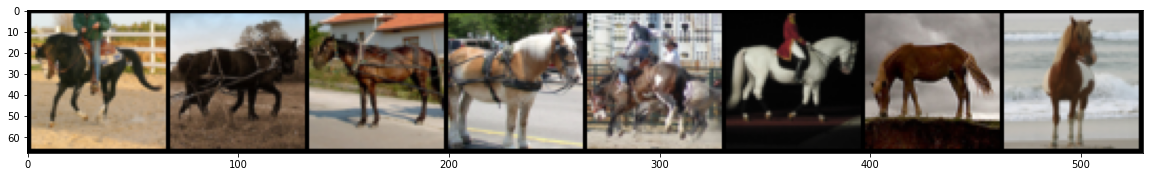

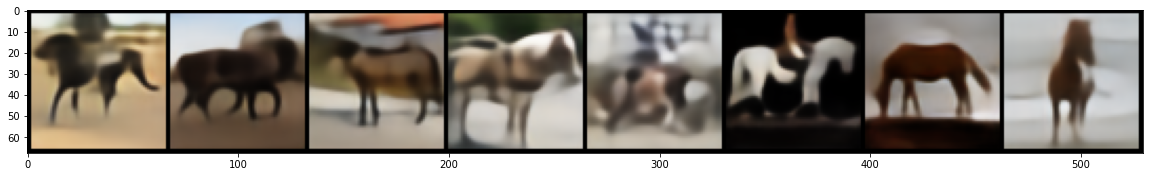

In [5]:
'''training code - based on code from
https://github.com/LukeDitria/CNN-VAE
'''
''' calculate the vae loss by imposing the unit normal distribution on the 
latent space using Kulback-Liebler divergence loss + reconstruction loss'''
def vae_loss(recon, x, mu, logvar):
  recon_loss = F.binary_cross_entropy_with_logits(recon, x)
  KL_loss = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
  loss = recon_loss + 0.01 * KL_loss
  return loss

# linear annealing of the learning rate
def lr_Linear(epoch_max, epoch, lr):
  lr_adj = ((epoch_max-epoch)/epoch_max)*lr
  set_lr(lr = lr_adj)

# helper function so set learning rate
def set_lr(lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

net = Autoencoder(channel_in=n_channels, z=latent_size).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# get some test images for visualizing reconstruction
test_images = test_iter.next()[0]

# try to load a training checkpoint save if there is one
if load_save:
  try:
    params = torch.load('drive/My Drive/training/save.chkpt')
    net.load_state_dict(params['net'])
    optimizer.load_state_dict(params['optimizer'])
    start_epoch = params['epoch']
    print("Resuming training session from save.chkpt")
  except:
    print("Starting fresh training session")

for epoch in range(start_epoch, n_epoch):
  # linearly anneal the learning rate
  lr_Linear(n_epoch, epoch, learning_rate)
  # iterate through batches from stl10 
  for i, data in enumerate(train_loader, 0):
    data = data[0].to(device)

    recon_data, mu, logvar = net(data)
        
    # compute the loss
    loss = vae_loss(recon_data, data, mu, logvar)
        
    # backprop and update network
    net.zero_grad()
    loss.backward()
    optimizer.step()
      
  with torch.no_grad():
    print('Epoch: [%d/%d], loss: %.4f' 
                % (epoch, n_epoch, loss.item()))
    
    # reconstruct some test data and visualize it 
    recon_data, _, _ = net(test_images.to(device), Train = False)
    recon_data = torch.sigmoid(recon_data.cpu())

    plt.figure(figsize = (20,10))
    out = torchvision.utils.make_grid(test_images[0:8])
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.show()
    plt.pause(0.0001)

    plt.figure(figsize = (20,10))
    out = torchvision.utils.make_grid(recon_data[0:8])
    plt.imshow(out.numpy().transpose((1, 2, 0)))
    plt.show()
    plt.pause(0.0001)

    torch.save({'net':net.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}, 'drive/My Drive/training/save.chkpt')
        

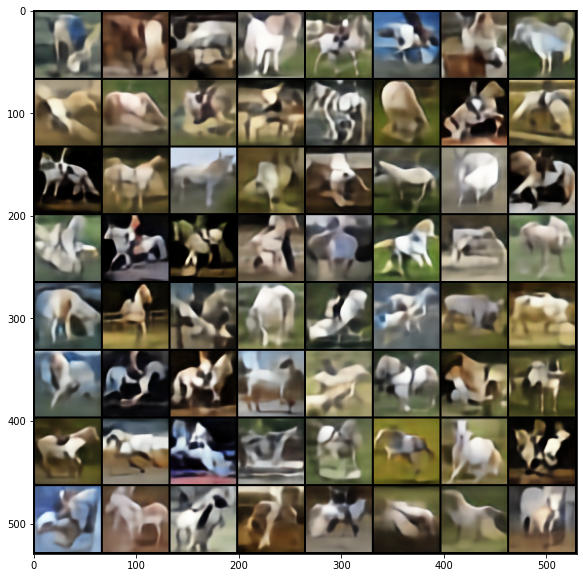

In [6]:
'''pegasus batch generator - sampling method based on a similar idea from this code
https://github.com/hsinyilin19/ResNetVAE/blob/master/ResNetVAE_reconstruction.ipynb
'''

# setup sample iterator (so we can just run this code again and again)
bird_sample_iter = iter(bird_sample_loader)
horse_sample_iter = iter(horse_sample_loader)

def generate_pegasus():
  with torch.no_grad():
    bird_samples = bird_sample_iter.next()[0].to(device)
    horse_samples = horse_sample_iter.next()[0].to(device)

    w = 0.4
    
    bird_encodings, _, _ = net.encoder(bird_samples, Train=False)
    horse_encodings, _, _ = net.encoder(horse_samples, Train=False)
    '''
    we multiply some of the latent spaces by negative one to effectively flip the colour of their reconstruction
    we do this becuase some of the wings of the birds are black and we want them to be'''
    neg_indices = torch.tensor([1, 4, 6, 8,9,10,11,12,13,15,16,18,21,23,25,26,
                                28,30,33,34,38,41,42,43,45,46,47,48,49,50,51,56,58,60,62]).to(device)
    pos_indices = torch.tensor([0,2,3,5,7,14,17,19,20,22,24,27,29,31,32,35,36,
                                37,39,40,44,52,53,54,55,57,59,61,63]).to(device)
    
    bird_encodings = torch.cat((bird_encodings[neg_indices] * (-1), bird_encodings[pos_indices]), 0)
    bird_encodings=bird_encodings[torch.randperm(bird_encodings.size()[0]).to(device)]

    pegasus_encodings = horse_encodings * (1-w) + bird_encodings * w
    pegasus_samples = net.decoder(pegasus_encodings)
    return torch.sigmoid(pegasus_samples.cpu())

# generate a batch of pegasuses and plot them
pegasus_batch = generate_pegasus()

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(pegasus_batch)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.show()
plt.pause(0.0001)